In [3]:
%autoreload 2

In [4]:
from collections import defaultdict
from argparse import Namespace
import copy
import gzip
import itertools
import math
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import duckdb
from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from Levenshtein import distance as _edit_distance
import numpy as np
import pandas as pd
import tabulate
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tabulate
from tqdm.notebook import tqdm
from scipy import stats
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id, deepcopy_ast, replace_child
from src.ast_printer import ast_to_lines
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *
from src import fitness_features_by_category, latest_model_paths

2023-12-04 17:35:10 - ast_utils - DEBUG    - Using cache folder: /Users/guydavidson/tmp/game_generation_cache
2023-12-04 17:35:10 - src.ast_utils - DEBUG    - Using cache folder: /Users/guydavidson/tmp/game_generation_cache


In [5]:

grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


2023-12-04 17:35:12 - ast_utils - INFO     - Loading from cache file: /Users/guydavidson/tmp/game_generation_cache/interactive-beta-cache.pkl.gz
2023-12-04 17:35:12 - ast_utils - INFO     - Finished loading cache file: /Users/guydavidson/tmp/game_generation_cache/interactive-beta-cache.pkl.gz


In [6]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_prop,variables_used_all,variables_used_prop,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1.0,1,1.0,...,0.969177,0.979573,0.965285,0.976289,0.977376,0.980148,0.915272,0.960175,0.999188,1.000000
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1.0,1,1.0,...,0.974875,0.978991,0.961082,0.972691,0.971810,0.980943,0.895362,0.910697,0.963311,0.973001
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1.0,1,1.0,...,0.954233,0.972808,0.000000,0.000000,0.000000,0.000000,0.841097,0.898279,0.946597,0.955042
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1.0,1,1.0,...,0.986178,0.982877,0.000000,0.000000,0.000000,0.000000,0.915272,0.960175,0.999188,1.000000
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1.0,1,1.0,...,0.984002,0.979782,0.000000,0.000000,0.000000,0.000000,0.964905,0.971973,0.972563,0.962818


In [5]:
postprocessor = ast_parser.ASTSamplePostprocessor()
postprocessed_real_game_texts = [ast_printer.ast_to_string(postprocessor(ast), '\n') for ast in game_asts]  # type: ignore

real_game_edit_distances = np.zeros((len(game_asts), len(game_asts)), dtype=int)
for i, j in itertools.combinations(range(len(game_asts)), 2):
    real_game_edit_distances[i, j] = real_game_edit_distances[j, i] = edit_distance(postprocessed_real_game_texts[i], postprocessed_real_game_texts[j])


def edit_distance(first_game_text: str, second_game_text: str):
    first_game_text = first_game_text[first_game_text.find(')', first_game_text.find('(:domain')) + 1:]
    second_game_text = second_game_text[second_game_text.find(')', second_game_text.find('(:domain')) + 1:]
    return _edit_distance(first_game_text, second_game_text)


def find_nearest_real_game_indices(game, k: int = 3) -> typing.Tuple[np.ndarray, np.ndarray]:
    game_str = ast_printer.ast_to_string(game, '\n')
    distances = np.array([edit_distance(game_str, real_game) for real_game in postprocessed_real_game_texts])
    nearest_real_game_indices = np.argsort(distances)[:k]
    return nearest_real_game_indices, distances[nearest_real_game_indices]


def print_nearest_real_games(game, k: int = 3):
    indices, distances = find_nearest_real_game_indices(game, k)
    for i, (idx, d) in enumerate(zip(indices, distances)):
        real_game_distances = real_game_edit_distances[idx]
        nearest_distance_indices = np.argsort(real_game_distances)[1:k + 1]  # index 0 is the game itself
        display(Markdown(f'### Nearest real game #{i + 1}:'))
        display(Markdown(f'Edit distance to sample {d}, real game nearest neighbor distances {np.array2string(real_game_distances[nearest_distance_indices], separator=", ")}):\n'))
        display(Markdown(f'```pddl\n{real_game_texts[idx]}\n```'))


In [6]:
HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS = dict(hspace=0.3)


def plot_value_histograms(results_by_feature_name_and_value: typing.Dict[str, typing.Dict[int, typing.List[float]]],
    bins: int = 20, histogram_log_y: bool = False, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = HISTOGRAMS_SUBPLOTS_ADJUST_PARAMS,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    k = len(results_by_feature_name_and_value.keys())

    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    for i, feature_name in enumerate(results_by_feature_name_and_value.keys()):
        if layout[0] == 1:
            ax = axes[i]
        else:
            ax = axes[i // layout[1]][i % layout[1]]

        values_with = results_by_feature_name_and_value[feature_name][1]
        values_without = results_by_feature_name_and_value[feature_name][0]

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([values_with, values_without], label=[f'1 (n={len(values_with)})', f'0 (n={len(values_without)})'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Fitness value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title = f'#{i + 1}: {feature_name}'
        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()


def analyze_archive_fullness(model: MAPElitesSampler, mutually_exclusive_features: typing.Optional[typing.List[str]] = None,
                             plot_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):
    if plot_kwargs is None:
        plot_kwargs = {}
    
    results_by_feature_name = {feature_name: defaultdict(list) for feature_name in model.map_elites_feature_names}
    results_by_feature_count = defaultdict(list)

    for key, fitness_value in model.fitness_values.items():
        for feature_name, feature_value in model._key_to_feature_dict(key).items():
            results_by_feature_name[feature_name][feature_value].append(fitness_value)

        if isinstance(key, int):
            key_bits = count_set_bits(key)
        else:
            key_bits = sum(k != 0 for k in key)

        results_by_feature_count[key_bits].append(fitness_value)

    display(Markdown(f'## Archive fullness analysis'))
    display(Markdown(f'Ttoal of {len(model.fitness_values)} samples in archive, {len(model.map_elites_feature_names)} features'))
    display(Markdown(f'### Results by feature'))
    lines = []
    for feature_name, results in results_by_feature_name.items():
        lines.append(f'- {feature_name}:')
        for feature_value in sorted(results.keys()):
            value_results = results[feature_value]
            lines.append(f'    - ={feature_value}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)})')

    display(Markdown('\n'.join(lines)))

    display(Markdown(f'### Results by set feature count'))
    lines = []
    for feature_count in sorted(results_by_feature_count.keys()):
        value_results = results_by_feature_count[feature_count]
        lines.append(f'- set-count={feature_count}: {np.mean(value_results):.3f} ± {np.std(value_results):.3f} (n={len(value_results)} / {math.comb(len(model.map_elites_feature_names), feature_count)})')

    display(Markdown('\n'.join(lines)))

    plot_value_histograms(results_by_feature_name, **plot_kwargs)


In [7]:
SUBPLOTS_ADJUST_PARAMS = dict(top=0.925)
DEFAULT_IGNORE_METRICS = ['Timestamp']


FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = './figures'


def save_plot(save_path, bbox_inches='tight', should_print=False):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        save_path = os.path.abspath(save_path)
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')



def plot_sampler_fitness_trajectory(
        evo: PopulationBasedSampler, title: typing.Optional[str] = None, 
        axsize: typing.Tuple[int, int] = (8, 6),
        plot_metrics: typing.Optional[bool] = None, 
        ignore_metrics: typing.Optional[typing.List[str]] = DEFAULT_IGNORE_METRICS,
        subplots_adjust_params: typing.Dict[str, float] = SUBPLOTS_ADJUST_PARAMS,
        min_real_game_fitness: typing.Optional[float] = None, max_real_game_fitness: typing.Optional[float] = None,
        mean_real_game_fitness: typing.Optional[float] = None, 
        vertical: bool = True,
        fontsize: int = 16,
        save_path: typing.Optional[str] = None): 
    
    if min_real_game_fitness is None or max_real_game_fitness is None:
        raise ValueError('min_real_game_fitness and max_real_game_fitness must be specified')

    if plot_metrics is None:
        plot_metrics = hasattr(evo, 'archive_metrics_history') and len(evo.archive_metrics_history) > 0  # type: ignore

    if ignore_metrics is None:
        ignore_metrics = []
    
    if not plot_metrics:
        layout = (1, 1)
    elif vertical:
        layout = (2, 1)
    else:
        layout = (1, 2)

    figsize = (axsize[0] * layout[1], axsize[1] * layout[0])

    fig, axes = plt.subplots(*layout, figsize=figsize)

    mean, max_fit, std = [], [], []
    for step_dict in evo.fitness_metrics_history:
        mean.append(step_dict['mean'])
        max_fit.append(step_dict['max'])
        std.append(step_dict['std'])

    mean = np.array(mean)
    max_fit = np.array(max_fit)
    std = np.array(std)

    fitness_ax = typing.cast(matplotlib.axes.Axes, axes[0] if plot_metrics else axes)

    fitness_ax.plot(mean, label='MAP-Elites fitness mean')
    fitness_ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2, label='MAP-Elites fitness std')  # type; ignore
    fitness_ax.plot(max_fit, label='MAP-Elites fitness max')

    fitness_ax.hlines(min_real_game_fitness, 0, len(mean), label='Real game fitness range', color='black', ls='--')
    fitness_ax.hlines(max_real_game_fitness, 0, len(mean), color='black', ls='--')

    if mean_real_game_fitness is not None:
        fitness_ax.hlines(mean_real_game_fitness, 0, len(mean), label='Real game fitness mean', color='black', ls=':')

    fitness_ax.set_xlabel('Generation', fontsize=fontsize)
    fitness_ax.set_ylabel('Fitness', fontsize=fontsize)

    fitness_ax.legend(loc='best', fontsize=fontsize)
    fitness_ax.tick_params(axis='both', which='major', labelsize=fontsize)
    
    if plot_metrics:
        metrics = {key: [] for key in evo.archive_metrics_history[0].keys() if key not in ignore_metrics}  # type: ignore
        for step_dict in evo.archive_metrics_history:  # type: ignore
            for key, value in step_dict.items():
                if key in metrics:
                    metrics[key].append(value)

        metrics_ax = typing.cast(matplotlib.axes.Axes, axes[1])
        for key, values in metrics.items():
            metrics_ax.plot(values, label=key.title())

        metrics_ax.set_xlabel('Generation', fontsize=fontsize)
        metrics_ax.set_ylabel('Number of games reaching threshold', fontsize=fontsize)

        metrics_ax.legend(loc='best', fontsize=fontsize)
        metrics_ax.tick_params(axis='both', which='major', labelsize=fontsize)

        plt.subplots_adjust(**subplots_adjust_params)
        
    if title is not None:
        if plot_metrics:
            plt.suptitle(title)
        else:
            plt.title(title)

    if save_path is not None:
        save_plot(save_path)

    plt.show()


def count_games_above_fitness_threshold(evo: PopulationBasedSampler, threshold: float) -> int:
    if isinstance(evo.fitness_values, dict):
        fitness_values = evo.fitness_values.values()
    else:
        fitness_values = evo.fitness_values

    return sum(1 for fitness in fitness_values if fitness >= threshold)

In [8]:
REPRESENTATIVE_GAME_INDICES = [26, 58, 42, 31, 48, 19, 14, 62, 93] 


NEW_REPRESENTATIVE_INDICES = [
    42,  # throw
    58,  # funny throw with setup
    28,  # throw, throw attempt, with setup 
    88,  # throw, throw attempt, no setup
    31,  # throw without in/on
    64,  # dropping ball in bin, drop attempt
    52,  # ball-less throwing game
    86,  # weird throw, with setup
    6,  # two weird throwing preferences, setup
    17,  # anoter weird multi throwing preference game
    96,  # three throwing preferences, setup
    
    14,  # castle building
    45,  # weird building game
    49,  # another weird building game
    51,  # hybrid throwing/building game
    
    23,  # single placement preference
    44,  # three different placement preferencs 

    26,  # single preferece that matches none of the others
]

WARNING_YELLOW_BG_COLOR = '#F1EB9C'

GAME_INDEX = 0
GAME_AST = 1
GAME_FITNESS = 2
GAME_KEY = 3
SAMPLE_FITNESS = 4
SAMPLE_AST = 5


CUSTOM_BACKGROUND_COLOR_CLASSES = ('bg-info', 'bg-warning', 'bg-success', 'bg-danger', 'bg-primary', 'bg-secondary', 'bg-dark', 'bg-light')


def _format_ast_for_html(ast, line_delimiter='<br>', increment='  ',):
    return f'<pre><code>{ast_printer.ast_to_string(ast, line_delimiter, increment=increment)}</code></pre>'


def make_representative_game_table(model: MAPElitesSampler, trace_filter_data: typing.Optional[typing.Dict[str, typing.Any]] = None,
                                   representative_game_indices: typing.Optional[typing.List[int]] = REPRESENTATIVE_GAME_INDICES, 
                                   real_game_asts=game_asts, line_delimiter='<br>', increment='  ', tablefmt='unsafehtml'):
    real_game_fitness_scores, real_game_fitness_features = zip(*[model._score_proposal(game, return_features=True) for game in real_game_asts])  # type: ignore
    real_game_fitness_score_indices = np.argsort(real_game_fitness_scores)[::-1]  # type: ignore

    # If not provided, take the highest fitness game in each cell
    cells_occupied = set()
    if representative_game_indices is None:
        representative_game_indices = []

        for real_game_index in real_game_fitness_score_indices:
            real_game = real_game_asts[real_game_index]
            real_game_key = model._features_to_key(real_game, real_game_fitness_features[real_game_index])
            if real_game_key not in cells_occupied:
                representative_game_indices.append(real_game_index)
                cells_occupied.add(real_game_key)

    rows = [[] for _ in range(6)]

    for idx in representative_game_indices:
        real_game = real_game_asts[idx]
        real_game_key = model._features_to_key(real_game, real_game_fitness_features[idx])
        if real_game_key is None:
            continue

        real_game_rank = np.where(real_game_fitness_score_indices == idx)[0][0]
        rows[GAME_INDEX].append(f'Game #{idx} (fitness rank {real_game_rank})')

        real_game_ast_str = _format_ast_for_html(real_game_asts[idx], line_delimiter=line_delimiter, increment=increment)
        rows[GAME_AST].append(real_game_ast_str)

        fitness = real_game_fitness_scores[idx]
        rows[GAME_FITNESS].append(f'<strong>Real game fitness: {fitness:.4f}</<strong>')
        
        key_dict = model._key_to_feature_dict(real_game_key)
        key_dict_str = '<br>'.join([f'<strong>Key {real_game_key}:</strong>'] + [f'{feature_name}: {feature_value}' for feature_name, feature_value in key_dict.items()])
        rows[GAME_KEY].append(key_dict_str)

        if real_game_key in model.population:
            sample = model.population[real_game_key]
            sample_fitness = model.fitness_values[real_game_key]
            custom_class = 'placeholder'
            postfix = ''

            if trace_filter_data is not None and real_game_key in trace_filter_data['summary']:
                sample_trace_filter_result = trace_filter_data['summary'][real_game_key]
                postfix = f' (trace filter result: {sample_trace_filter_result})'
                
                if sample_trace_filter_result == -1:
                    custom_class = 'bg-info'
                
                elif sample_trace_filter_result == 0:
                    custom_class = 'bg-warning'

                else:
                    custom_class = 'bg-success'

            rows[SAMPLE_FITNESS].append(f'<div class="{custom_class}"><strong>Sample fitness: {sample_fitness:.4f}{postfix}</strong></div>')

            sample_ast_str = _format_ast_for_html(sample, line_delimiter=line_delimiter, increment=increment)
            rows[SAMPLE_AST].append(sample_ast_str)

        else:
            rows[SAMPLE_FITNESS].append('No sample found')
            rows[SAMPLE_AST].append('N/A')

    return tabulate.tabulate(rows, headers='firstrow', tablefmt=tablefmt)



def make_samples_only_game_table(model: MAPElitesSampler, sample_keys: typing.List[KeyTypeAnnotation],
                                 trace_filter_data: typing.Optional[typing.Dict[str, typing.Any]] = None,
                                 line_delimiter='<br>', increment='  ', tablefmt='unsafehtml'):

    rows = defaultdict(list)

    for sample_key in sample_keys:
        key_dict = model._key_to_feature_dict(sample_key)
        key_dict_str = '<br>'.join([f'<strong>Key {sample_key}:</strong>'] + [f'{feature_name}: {feature_value}' for feature_name, feature_value in key_dict.items()])
        rows[GAME_KEY].append(key_dict_str)

        sample = model.population[sample_key]
        sample_fitness = model.fitness_values[sample_key]
        custom_class = 'placeholder'
        postfix = ''

        if trace_filter_data is not None and sample_key in trace_filter_data['summary']:
            sample_trace_filter_result = trace_filter_data['summary'][sample_key]
            postfix = f' (trace filter result: {sample_trace_filter_result})'
            
            if sample_trace_filter_result == -1:
                custom_class = 'bg-info'
            
            elif sample_trace_filter_result == 0:
                custom_class = 'bg-warning'

            else:
                custom_class = 'bg-success'

        rows[SAMPLE_FITNESS].append(f'<div class="{custom_class}"><strong>Sample fitness: {sample_fitness:.4f}{postfix}</strong></div>')

        sample_ast_str = _format_ast_for_html(sample, line_delimiter=line_delimiter, increment=increment)
        rows[SAMPLE_AST].append(sample_ast_str)

    return tabulate.tabulate([rows[SAMPLE_FITNESS], rows[GAME_KEY], rows[SAMPLE_AST]], tablefmt=tablefmt)



def make_representative_game_table_to_html(table_html: str, model_name: str, real_game_energy_range: typing.Tuple[float, float], output_path='representative_games.html'):
    table_html = table_html.replace('<table>', '<table class="table table-striped table-bordered">')
    table_html = table_html.replace('<thead>', '<thead class="thead-dark">')
    table_html = table_html.replace('<th>', '<th scope="col">')
    for custom_class in CUSTOM_BACKGROUND_COLOR_CLASSES:
        table_html = table_html.replace(f'<td><div class="{custom_class}">', f'<td class="{custom_class}"><div>')
    
    style = """
    <style>
        .table td, .table th {
            min-width: 40em;
            max-width: 60em;
        }
        pre {
            white-space: pre-wrap;
            max-height: 60em;
            overflow: auto;
            display: inline-block;
        }
    </style>
    """

    html_template = f"""
    <html lang="en">
    <head>
        <meta charset="utf-8">
        <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no">
        <title>Representative games comparison</title>
        <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@4.0.0/dist/css/bootstrap.min.css" integrity="sha384-Gn5384xqQ1aoWXA+058RXPxPg6fy4IWvTNh0E263XmFcJlSAwiGgFAW/dAiS6JXm" crossorigin="anonymous">
        {style}
    </head>
    <body>
        <div>
            <h1>Representative games comparison for {model_name}</h1>
            <h3>Real game energy range: min: {real_game_energy_range[0]:.4f}, max: {real_game_energy_range[1]:.4f}</h3>
            Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
            {table_html}
        </div>
        <script src="https://code.jquery.com/jquery-3.2.1.slim.min.js" integrity="sha384-KJ3o2DKtIkvYIK3UENzmM7KCkRr/rE9/Qpg6aAZGJwFDMVNA/GpGFF93hXpG5KkN" crossorigin="anonymous"></script>
        <script src="https://cdn.jsdelivr.net/npm/popper.js@1.12.9/dist/umd/popper.min.js" integrity="sha384-ApNbgh9B+Y1QKtv3Rn7W3mgPxhU9K/ScQsAP7hUibX39j7fakFPskvXusvfa0b4Q" crossorigin="anonymous"></script>
        <script src="https://cdn.jsdelivr.net/npm/bootstrap@4.0.0/dist/js/bootstrap.min.js" integrity="sha384-JZR6Spejh4U02d8jOt6vLEHfe/JQGiRRSQQxSfFWpi1MquVdAyjUar5+76PVCmYl" crossorigin="anonymous"></script>
    </body>
    """

    with open(output_path, 'w') as f:
        f.write(html_template)


def make_and_save_representative_game_table(model, model_name, real_game_energy_range: typing.Tuple[float, float],
                                            trace_filter_data: typing.Optional[typing.Dict[str, typing.Any]] = None,
                                            representative_game_indices=REPRESENTATIVE_GAME_INDICES, 
                                            real_game_asts=game_asts, line_delimiter='<br>', increment='  ', tablefmt='unsafehtml'):
    table_html = make_representative_game_table(model, trace_filter_data=trace_filter_data, representative_game_indices=representative_game_indices, 
                                                real_game_asts=real_game_asts, line_delimiter=line_delimiter, increment=increment, tablefmt=tablefmt)

    prefix = 'representative_games' if representative_game_indices is not None else 'all_representative_games'
    output_path = f'./output_htmls/{prefix}_{model.output_name}_{datetime.now().strftime("%Y_%m_%d")}.html'
    print(f'Saving representative games table to {os.path.abspath(output_path)}')
    make_representative_game_table_to_html(table_html, model_name, real_game_energy_range, output_path)


def plot_fitness_trajectory_and_make_game_table(model: MAPElitesSampler, title: str, 
                                                representative_game_indices=REPRESENTATIVE_GAME_INDICES, 
                                                save_path: typing.Optional[str] = None, 
                                                make_table: bool = True, plot_metrics: typing.Optional[bool] = None):
    min_real_game_fitness =  -1 * model.fitness_function.score_dict['max']
    max_real_game_fitness = -1 * model.fitness_function.score_dict['min']
    mean_real_game_fitness = -1 * model.fitness_function.score_dict['mean']
    plot_sampler_fitness_trajectory(model, title, plot_metrics=plot_metrics,
                                    min_real_game_fitness=min_real_game_fitness, 
                                    max_real_game_fitness=max_real_game_fitness, 
                                    mean_real_game_fitness=mean_real_game_fitness,
                                    save_path=save_path)
    if make_table:
        make_and_save_representative_game_table(model, title, 
                                                real_game_energy_range=(min_real_game_fitness, max_real_game_fitness),
                                                representative_game_indices=representative_game_indices)


def make_and_save_samples_game_table(model, model_name, sample_keys: typing.Optional[typing.List[KeyTypeAnnotation]] = None,
                                     n_top_samples: int = 10, 
                                     trace_filter_data: typing.Optional[typing.Dict[str, typing.Any]] = None,
                                     real_game_asts=game_asts, line_delimiter='<br>', increment='  ', tablefmt='unsafehtml'):
    
    if sample_keys is None:
        real_game_fitness_features = [model._proposal_to_features(game) for game in real_game_asts]
        cells_occupied = set([model._features_to_key(game, features) for game, features in zip(real_game_asts, real_game_fitness_features)])

        sample_keys = []
        fitness_values_and_keys = [(fitness, key) for key, fitness in model.fitness_values.items()]
        fitness_values_and_keys.sort(reverse=True)

        for _, key in fitness_values_and_keys:
            if key not in cells_occupied:
                sample_keys.append(key)
                cells_occupied.add(key)

            if len(sample_keys) >= n_top_samples:
                break
    
    table_html = make_samples_only_game_table(model, sample_keys, trace_filter_data=trace_filter_data, 
                                              line_delimiter=line_delimiter, increment=increment, tablefmt=tablefmt)

    prefix = 'map_elites_samples'
    output_path = f'./output_htmls/{prefix}_{model.output_name}_{datetime.now().strftime("%Y_%m_%d")}.html'
    print(f'Saving representative games table to {os.path.abspath(output_path)}')

    min_real_game_fitness =  -1 * model.fitness_function.score_dict['max']
    max_real_game_fitness = -1 * model.fitness_function.score_dict['min']
    make_representative_game_table_to_html(table_html, model_name, (min_real_game_fitness, max_real_game_fitness), output_path)



In [9]:
REAL_GAME_HEADER = 0
REAL_GAME_TEXT = 1
REAL_GAME = 2
MAP_ELITES_HEADER = 3
MAP_ELITES_TEXT = 4
MAP_ELITES_GAME = 5


LATEX_GAME_TEMPLATE = r"""
\begin{{lstlisting}}[aboveskip=-0.4 \baselineskip,belowskip=-0.8 \baselineskip]
{ast_string}
\end{{lstlisting}}
""".strip()


LATEX_TABLE_TEMPLATE = r"""
\begin{{table}}[!htbp]
    \caption{{\TODO[insert caption here]}}
    \begin{{adjustbox}}{{center}}
    \begin{{tabular}}{{|p{{\gamecolumnwidth}}|p{{\gamecolumnwidth}}|p{{\gamecolumnwidth}}|}}
    \toprule
    {table_text}
    \bottomrule
    \end{{tabular}}
    \end{{adjustbox}}
    \TODO[Insert any text below the table, if desired]
    \label{{tab:{table_label}}}
\end{{table}}
""".strip()


LATEX_DESCRIPTION_ONLY_TABLE_TEMPLATE = r"""
\begin{{table}}[!htbp]
    \caption{{\TODO[insert caption here]}}
    \begin{{adjustbox}}{{center}}
    \begin{{tabular}}{{|p{{\textcolumnwidth}}|p{{\textcolumnwidth}}|}}
    \toprule
    \textbf{{Real Games}} & \textbf{{MAP-Elites Samples}} \\
    \midrule
    {table_text}
    \bottomrule
    \end{{tabular}}
    \end{{adjustbox}}
    \TODO[Insert any text below the table, if desired]
    \label{{tab:{table_label}}}
\end{{table}}
""".strip()


LATEX_SAMPLE_DESCRIPTION_ONLY_TABLE_TEMPLATE = r"""
\begin{{table}}[!htbp]
    \caption{{\TODO[insert caption here]}}
    \begin{{adjustbox}}{{center}}
    \begin{{tabular}}{{|p{{\textcolumnwidth}}|}}
    \toprule
    \textbf{{Novel MAP-Elites Samples}} \\
    \midrule
    {table_text}
    \bottomrule
    \end{{tabular}}
    \end{{adjustbox}}
    \TODO[Insert any text below the table, if desired]
    \label{{tab:{table_label}}}
\end{{table}}
""".strip()


def _format_ast_for_latex(ast):
    ast_lines = ast_to_lines(ast, increment='  ')
    reformatted_lines = []
    buffer = []

    combining_lines = False
    for line in ast_lines:
        current_line_is_only_paren = line.strip() == ')'

        if current_line_is_only_paren:
            combining_lines = True
            buffer.append(line)

        elif combining_lines:
            combining_lines = False
            new_line = buffer[-1].replace(')', ')' * len(buffer))
            reformatted_lines.append(new_line)

            reformatted_lines.append(line)

            buffer = []

        else:
            reformatted_lines.append(line)       

    if len(buffer) > 0:
        new_line = buffer[-1].replace(')', ')' * len(buffer))
        reformatted_lines.append(new_line)

    ast_string = '\n'.join(reformatted_lines)

    return LATEX_GAME_TEMPLATE.format(ast_string=ast_string)


def make_representative_game_table_latex(model, table_label: str,
                                            trace_filter_data: typing.Optional[typing.Dict[str, typing.Any]] = None,
                                            real_game_descriptions: typing.Optional[typing.Dict[int, str]] = None,
                                            map_elites_sample_descriptions: typing.Optional[typing.Dict[int, str]] = None,
                                            representative_game_indices=REPRESENTATIVE_GAME_INDICES, 
                                            real_game_asts=game_asts, description_text_size: str = 'tiny'):
    
    rows = defaultdict(list)
    
    for idx in representative_game_indices:
        real_game_ast = real_game_asts[idx] 
        real_game_fitness_score, real_game_features = model._score_proposal(real_game_ast, return_features=True)

        real_game_key = model._features_to_key(real_game_ast, real_game_features)
        rows[REAL_GAME_HEADER].append(f'\\textbf{{Real Game \\#{idx} (fitness {real_game_fitness_score:.4f})}}')
        rows[REAL_GAME_TEXT].append(r'\TODO[describe real game here]' if real_game_descriptions is None else f'{{\\{description_text_size} {real_game_descriptions[idx]} }}')
        rows[REAL_GAME].append(_format_ast_for_latex(real_game_ast))

        map_elites_game = model.population[real_game_key]
        map_elites_fitness_score = model.fitness_values[real_game_key]
        rows[MAP_ELITES_HEADER].append(f'\\textbf{{MAP-Elites Sample (fitness {map_elites_fitness_score:.4f})}}')
        rows[MAP_ELITES_TEXT].append(r'\TODO[describe MAP-Elites sample here]' if map_elites_sample_descriptions is None else f'{{\\{description_text_size} {map_elites_sample_descriptions[idx]} }}')
        rows[MAP_ELITES_GAME].append(_format_ast_for_latex(map_elites_game))

    table_rows = []
    table_rows.append(' & '.join(rows[REAL_GAME_HEADER]) + r' \\')
    table_rows.append('\\midrule')
    table_rows.append(' & '.join(rows[REAL_GAME_TEXT]) + r' \\')
    table_rows.append(' & '.join(rows[REAL_GAME]) + r' \\')
    table_rows.append('\\midrule')
    table_rows.append(' & '.join(rows[MAP_ELITES_HEADER]) + r' \\')
    table_rows.append('\\midrule')
    table_rows.append(' & '.join(rows[MAP_ELITES_TEXT]) + r' \\')
    table_rows.append(' & '.join(rows[MAP_ELITES_GAME]) + r' \\')
    
    if table_label.startswith('tab:'):
        table_label = table_label[4:]

    table_text = '\n'.join(table_rows)
    return LATEX_TABLE_TEMPLATE.format(table_text=table_text, table_label=table_label)
    

def make_samples_only_table_latex(model, table_label: str, sample_keys: typing.List[KeyTypeAnnotation], 
                                  map_elites_sample_descriptions: typing.Optional[typing.Dict[KeyTypeAnnotation, str]] = None,
                                  description_text_size: str = 'tiny'):
    

    rows = defaultdict(list)
    for key in sample_keys:
        sample = model.population[key]
        fitness = model.fitness_values[key]
        rows[0].append(f'\\textbf{{MAP-Elites Sample (fitness {fitness:.4f})}}')
        rows[1].append(r'\TODO[describe sample here]' if map_elites_sample_descriptions is None else f'{{\\{description_text_size} {map_elites_sample_descriptions[key]} }}')
        rows[2].append(_format_ast_for_latex(sample))

    table_rows = []
    table_rows.append(' & '.join(rows[0]) + r' \\')
    table_rows.append('\\midrule')
    table_rows.append(' & '.join(rows[1]) + r' \\')
    table_rows.append(' & '.join(rows[2]) + r' \\')

    if table_label.startswith('tab:'):
        table_label = table_label[4:]

    table_text = '\n'.join(table_rows)
    return LATEX_TABLE_TEMPLATE.format(table_text=table_text, table_label=table_label)



def make_descriptions_only_table_latex(table_label: str,
        real_game_descriptions: typing.Dict[int, str],
        map_elites_sample_descriptions: typing.Dict[int, str],
        text_size: str = 'tiny',):
    
    midrule = "\\midrule"

    rows = [
        f'{{ \\{text_size} {real_game_descriptions[index]} }} &  {{ \\{text_size} {map_elites_sample_descriptions[index]} }} \\\\ {midrule if i < len(real_game_descriptions) - 1 else ""}'
        for i, index in enumerate(real_game_descriptions)
    ]

    table_text = '\n'.join(rows)
    return LATEX_DESCRIPTION_ONLY_TABLE_TEMPLATE.format(table_text=table_text, table_label=table_label)



def make_samples_only_descriptions_only_table(table_label: str,
                                              map_elites_sample_descriptions: typing.Dict[KeyTypeAnnotation, str],
                                              text_size: str = 'tiny'):
    
    midrule = "\\midrule"

    rows = [
        f'{{ \\{text_size} {desc} }} \\\\ {midrule if i < len(map_elites_sample_descriptions) - 1 else ""}'
        for i, (key, desc) in enumerate(map_elites_sample_descriptions.items())
    ]

    table_text = '\n'.join(rows)
    return LATEX_SAMPLE_DESCRIPTION_ONLY_TABLE_TEMPLATE.format(table_text=table_text, table_label=table_label)
        

In [10]:
FITNESS_COMPARISON_SCATTER_KWARGS = dict()
FITNESS_COMPARISON_LINE_KWARGS = dict()
FITNESS_COMPARISON_SUBPLOT_ADJUST_KWARGS = dict(hspace=0.3, wspace=0.1)


def plot_fitness_comparison_across_bins(
    models: typing.List[MAPElitesSampler],
    real_game_bins_only: bool = True,
    real_game_asts: typing.List[tuple] = game_asts,  # type: ignore
    n_rows: typing.Optional[int] = None,
    n_cols: typing.Optional[int] = None,
    color_by_margin: bool = True,
    underperforming_bin_threshold: int = 2,
    color_in_margin: str = 'purple',
    color_outside_margin: str = 'orange',
    width_per_bin: float = 2,
    height_per_bin: float = 2.5,
    baseline_fontsize: int = 8,
    scatter_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = FITNESS_COMPARISON_SCATTER_KWARGS,
    line_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = FITNESS_COMPARISON_LINE_KWARGS,
    subplot_adjust_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = FITNESS_COMPARISON_SUBPLOT_ADJUST_KWARGS, 
):
    if scatter_kwargs is None:
        scatter_kwargs = {}

    if line_kwargs is None:
        line_kwargs = {}

    if subplot_adjust_kwargs is None:
        subplot_adjust_kwargs = {}
    
    real_game_fitness_scores, real_game_features = zip(*[models[0]._score_proposal(game, return_features=True) for game in real_game_asts])  # type: ignore
    real_game_iqr = np.percentile(real_game_fitness_scores, 75) - np.percentile(real_game_fitness_scores, 25)
    real_game_keys = [models[0]._features_to_key(game, features) for game, features in zip(real_game_asts, real_game_features)]
    bins_to_real_game_indices = defaultdict(list)
    for idx, real_game_key in enumerate(real_game_keys):
        bins_to_real_game_indices[real_game_key].append(idx)

    if real_game_bins_only:
        n_bins = len(bins_to_real_game_indices)
        bins = list(sorted(bins_to_real_game_indices.keys()))
        
    else:
        n_bins_by_model = [len(model.population) for model in models]
        max_poulation_model_index = np.argmax(n_bins_by_model)
        n_bins = n_bins_by_model[max_poulation_model_index]
        bins = list(sorted(models[max_poulation_model_index].population.keys()))

    if n_rows is not None and n_cols is not None:
        assert n_rows * n_cols >= n_bins, f'Not enough rows and columns to fit {n_bins} bins'
    elif n_rows is not None:
        n_cols = math.ceil(n_bins / n_rows)
    elif n_cols is not None:
        n_rows = math.ceil(n_bins / n_cols)
    else:
        n_cols = math.ceil(math.sqrt(n_bins))
        n_rows = math.ceil(n_bins / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * width_per_bin, n_rows * height_per_bin))

    underperforming_bins = []

    for bin_idx, bin_key in enumerate(bins):
        ax = axes[bin_idx // n_cols, bin_idx % n_cols]
        title = f'({",".join([str(x) for x in bin_key])})' if isinstance(bin_key, tuple) else str(bin_key)
        
        ax.set_yticks([])
        ax.tick_params(axis='both', which='major', labelsize=baseline_fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=baseline_fontsize - 2)

        bin_fitness_values = [model.fitness_values[bin_key] for model in models]
        
        max_real_game_bin_fitness = None
        if bin_key in bins_to_real_game_indices:
            max_real_game_bin_fitness = max(real_game_fitness_scores[real_game_index] for real_game_index in bins_to_real_game_indices[bin_key])
            for real_game_index in bins_to_real_game_indices[bin_key]:
                real_game_fitness = real_game_fitness_scores[real_game_index]
                ax.axvline(real_game_fitness, alpha=0.75 if real_game_fitness == max_real_game_bin_fitness else 0.25, **line_kwargs)

        if color_by_margin and max_real_game_bin_fitness is not None:
            # iqr_count = len([fitness for fitness in bin_fitness_values if fitness >= max_real_game_bin_fitness - real_game_iqr])
            # title += f' (IQR: {iqr_count}/{len(bin_fitness_values)})'
            games_within_margin = [fitness >= max_real_game_bin_fitness - real_game_iqr for fitness in bin_fitness_values]
            if len(games_within_margin) - sum(games_within_margin) >= underperforming_bin_threshold:
                underperforming_bins.append(bin_key)

            c =  [color_in_margin if within_margin else color_outside_margin for within_margin in games_within_margin]
        else:
            c = color_outside_margin

        ax.scatter(bin_fitness_values, np.arange(1, len(models) + 1), c=c, **scatter_kwargs)

        ax.set_title(title, fontsize=baseline_fontsize + 2)

    x_mins, x_maxes = zip(*[axes[bin_idx // n_cols, bin_idx % n_cols].get_xlim() for bin_idx in range(len(bins))])
    x_min = min(x_mins)
    x_max = max(x_maxes)
    for ax in axes.flatten():
        ax.set_xlim(x_min, x_max)

    for spare_bin_idx in range(len(bins), n_rows * n_cols):
        ax = axes[spare_bin_idx // n_cols, spare_bin_idx % n_cols]
        ax.axis('off')

    plt.subplots_adjust(**subplot_adjust_kwargs)
    plt.show()
    return underperforming_bins

In [8]:
models, names = [], []

for model_key, model_spec in latest_model_paths.MAP_ELITES_MODELS.items():
    model = typing.cast(MAPElitesSampler, model_spec.load())
    # plot_fitness_trajectory_and_make_game_table(model, model_spec.name, representative_game_indices=NEW_REPRESENTATIVE_INDICES)
    models.append(model)
    names.append(model_spec.name)


2023-12-05 13:07:03 - compile_predicate_statistics_full_database - INFO     - Loading data from files
2023-12-05 13:07:19 - compile_predicate_statistics_full_database - INFO     - Creating DuckDB table...
2023-12-05 13:07:20 - compile_predicate_statistics_full_database - INFO     - Creating data table indices...
2023-12-05 13:07:40 - compile_predicate_statistics_full_database - INFO     - Loaded data, found 843825 rows


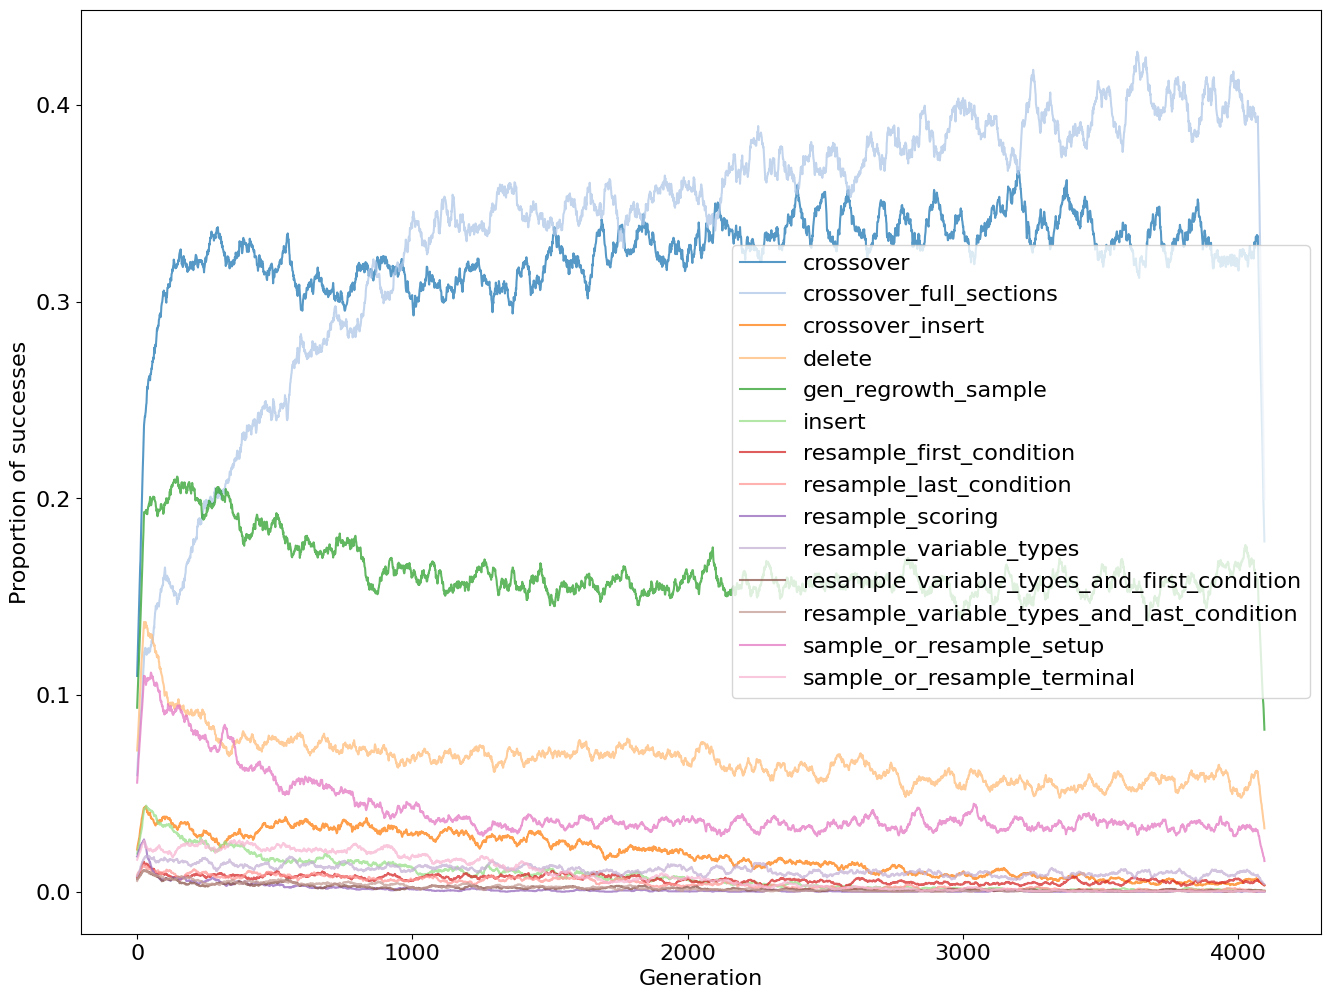

In [49]:
BASE_RATES = {
    'gen_regrowth_sample': 0.5 / 5,
    'insert': 0.5 / 5, 
    'delete': 0.5 / 5,
    'crossover': 0.5 / 5,
    'crossover_insert': 0.5 / 5,
    'resample_variable_types': 0.4 / 5,
    'resample_first_condition': 0.4 / 5,
    'resample_last_condition': 0.4 / 5,
    'resample_variable_types_and_first_condition': 0.4 / 5,
    'resample_variable_types_and_last_condition': 0.4 / 5,
    'sample_or_resample_setup': 0.1 / 4,
    'sample_or_resample_terminal': 0.1 / 4,
    'resample_scoring': 0.1 / 4,
    '_crossover_full_sections': 0.1 / 4,
}

BASE_RATES.update({f'_{key}': value for key, value in BASE_RATES.items()})


def plot_success_by_generation(model, normalize: bool = False, k: int = 5, normalize_base_rates: bool = True,
                               base_rates: typing.Optional[typing.Dict[str, float]] = BASE_RATES, 
                               cmap: str = 'tab10',
                               figsize: typing.Tuple[int, int] = (16, 12), fontsize: int = 16):
    all_keys = set()
    for step_success in model.success_by_generation_and_operator:
        all_keys.update(step_success.keys())

    all_keys = list(sorted(all_keys))
    successes_by_ket = {key: np.zeros(len(model.success_by_generation_and_operator)) for key in all_keys}

    for i, step_success in enumerate(model.success_by_generation_and_operator):
        if normalize:
            if normalize_base_rates:
                step_success = {key: value / base_rates[key] for key, value in step_success.items()}

            step_sum = sum(step_success.values())
            step_success = {key: value / step_sum for key, value in step_success.items()}

        for key in all_keys:
            successes_by_ket[key][i] = step_success.get(key, 0)

    kernel = np.ones(k) / k
    colormap = plt.cm.get_cmap(cmap)

    plt.figure(figsize=figsize)
    for key in all_keys:
        smoothed_successes = np.convolve(successes_by_ket[key], kernel, mode='same')
        updated_key = key.strip('_')
        plt.plot(smoothed_successes, label=updated_key, alpha=0.75, color=colormap(all_keys.index(key)))

    plt.xlabel('Generation', fontsize=fontsize)
    plt.ylabel('Successes' if not normalize else 'Proportion of successes', fontsize=fontsize)
    plt.legend(loc='best', fontsize=fontsize)
    plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
    plt.show()


plot_success_by_generation(models[-1], normalize=True, normalize_base_rates=False, k=50, cmap='tab20')



In [9]:
model = models[-1]
key_to_real_game_index = defaultdict(list)
real_game_keys = []
for i, ast in enumerate(game_asts):
    features = model._proposal_to_features(ast)
    key = model._features_to_key(ast, features)
    key_to_real_game_index[key].append(i)
    real_game_keys.append(key)



In [12]:
key_to_real_game_index

defaultdict(list,
            {(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0): [0],
             (1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0): [1, 28, 34, 63, 95],
             (1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0): [2, 14],
             (1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0): [3,
              30,
              42,
              54,
              66,
              68,
              71,
              78],
             (1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0): [4],
             (1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0): [5],
             (1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0): [6],
             (1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0): [7, 82],
             (1, 1, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0): [8],
             (1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0): [9, 10, 50, 58, 62, 72, 86],
             (1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0): [11],
             (1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0): [12],
             (1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0): [13,
              20,
              24,
              70,
              74,
      

In [40]:
trace_filter_results = utils.load_data_from_path('../samples/trace_filter_results_max_exemplar_preferences_by_bcs_with_expected_values_2023_11_29_2023_12_05_1.pkl.gz')
trace_filter_results.keys()

dict_keys(['summary', 'full'])

In [42]:
count = 0

for key in key_to_real_game_index:
    if key in trace_filter_results['summary'] and trace_filter_results['summary'][key] == 0:
        print('*', key, [k for k, v in trace_filter_results['full'][key].items() if len(v) == 0])
        count += 1

print(count, len(key_to_real_game_index), count / len(key_to_real_game_index))

* (1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0) ['(:setup']
* (1, 0, 3, 0, 0, 0, 0, 0, 2, 1, 0, 0) ['preference0']
* (1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1) ['preference1']
* (1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1) ['preference0']
4 47 0.0851063829787234


In [47]:
count_by_entry = defaultdict(lambda: defaultdict(int))

for key, score in trace_filter_results['summary'].items():
    if score == 0:
        for i, entry in enumerate(key):
            count_by_entry[i][entry] += 1

for i, counts in count_by_entry.items():
    print(i, counts)

0 defaultdict(<class 'int'>, {0: 198, 1: 182})
1 defaultdict(<class 'int'>, {1: 173, 0: 207})
2 defaultdict(<class 'int'>, {2: 15, 1: 5, 4: 304, 3: 56})
3 defaultdict(<class 'int'>, {0: 303, 1: 66, 2: 11})
4 defaultdict(<class 'int'>, {0: 225, 1: 93, 2: 45, 3: 16, 4: 1})
5 defaultdict(<class 'int'>, {0: 270, 2: 33, 1: 60, 3: 15, 4: 2})
6 defaultdict(<class 'int'>, {0: 321, 1: 52, 2: 7})
7 defaultdict(<class 'int'>, {0: 298, 2: 14, 1: 66, 3: 2})
8 defaultdict(<class 'int'>, {0: 284, 1: 69, 2: 22, 3: 4, 4: 1})
9 defaultdict(<class 'int'>, {0: 284, 1: 80, 2: 11, 3: 5})
10 defaultdict(<class 'int'>, {0: 262, 1: 84, 2: 23, 3: 8, 4: 3})
11 defaultdict(<class 'int'>, {1: 130, 0: 206, 2: 26, 3: 18})


In [48]:
preference_count_counts = defaultdict(int)
for key in models[-1].population:
    preference_count_counts[key[2]] += 1

for key, count in preference_count_counts.items():
    print(key, count, count_by_entry[2][key] / count)

1 40 0.125
2 220 0.06818181818181818
3 880 0.06363636363636363
4 2860 0.1062937062937063


In [ ]:
REPRESENTATIVE_GAME_INDICES = [26, 58, 42, 31, 48, 19, 14, 62, 93] 

real_game_fitness_scores, real_game_fitness_features = zip(*[model._score_proposal(game, return_features=True) for game in game_asts])  # type: ignore
real_game_fitness_score_indices = np.argsort(real_game_fitness_scores)[::-1]  # type: ignore 

relevant_indices = [-2, -1]

for key, indices in key_to_real_game_index.items():
    if len(relevant_indices) > 0:
        if key is None or not any(key[idx] for idx in relevant_indices):
            continue

    if len(indices) > 0:
        formatted_indices = []
        for idx in indices: 
            real_game_rank = np.where(real_game_fitness_score_indices == idx)[0][0]
            game_in_representative_games = idx in REPRESENTATIVE_GAME_INDICES
            marker = "*" if game_in_representative_games else ""
            formatted_indices.append((real_game_rank, f'{marker}{idx}{marker} (rank: {real_game_rank})'))

        formatted_indices.sort()

        print(f'{key}: {", ".join(t[1] for t in formatted_indices)}')


In [ ]:

NEW_REPRESENTATIVE_INDICES = [
    42,  # throw
    58,  # funny throw with setup
    28,  # throw, throw attempt, with setup 
    88,  # throw, throw attempt, no setup
    31,  # throw without in/on
    64,  # dropping ball in bin, drop attempt
    52,  # ball-less throwing game
    86,  # weird throw, with setup
    6,  # two weird throwing preferences, setup
    17,  # anoter weird multi throwing preference game
    96,  # three throwing preferences, setup
    
    14,  # castle building
    45,  # weird building game
    49,  # another weird building game
    51,  # hybrid throwing/building game
    
    23,  # single placement preference
    44,  # three different placement preferencs 

    26,  # single preferece that matches none of the others
]

In [ ]:
print(ast_printer.ast_to_string(game_asts[64], '\n'))

In [ ]:
real_game_descriptions = {
    14: "Build a `castle' by grabbing a bridge block, a flat block, a tall cylindrical block, a cube block, and a pyramid block, and stack them on top of each other in that order",
    42: "Throw dodgeballs into the bin. You get a point for each made throw.",
    62: "Set up the game by placing the hexagonal bin near the center of the room and all dodgeballs on the desk. To play, throw dodgeballs into the bin while standing next to the desk. You get a point for each made throw.",
    93: "Set up the game by placing the dodgeball near the center of the room. To play the game, make a building on top of the doggie bed, without objects touching the floor or a wall. You get a point for each object in the building.",
}

map_elites_sample_descriptions = {
    14: "Make buildings by grabbing a green bridge block, and placing any block and a pyramid block on it. The game ends once you make 12 such structures, and you get a point for each.",
    42: "Throw beachballs into the bin. The game ends after you've made 22 throws or 5 throws with different beachballs. You get a point for each made throw.",
    62: "Set up the game by placing the hexagonal bin very close to the top shelf. To play, put pink dodgeballs on the floor. Also, put the hexagonal bin upside down, and then flip to not be upside down without touching it or holding it. The game ends after you've put 8 pink dodgeballs on the floor or flipped the bin over 16 times. You get a point for each bin flip.",
    93: "Set up the game by placing the hexagonal bin very close to the east wall. To play, put blue cube blocks on shelves adjacent to the west wall, and place orange objects closer to the rug than to the door. The game ends after you've placed 23 blue cube blocks or 20 different orange objects, and you get a point for each blue cube block placed."
}


print(make_representative_game_table_latex(
    all_ngrams_uniform_new_bc_l2_model, 'comparison', 
    real_game_descriptions=real_game_descriptions,
    map_elites_sample_descriptions=map_elites_sample_descriptions,
    representative_game_indices=[42, 14, 93]))  # [42, 14, 62, 93]

In [ ]:
print(make_descriptions_only_table_latex('comparison-descriptions', real_game_descriptions, map_elites_sample_descriptions))

In [ ]:
candidate_sample_keys = [
    (1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1),
    (1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0),
    (1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1),
    (1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0),
    (1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1),
    (0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1),
    (1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1),
]

make_and_save_samples_game_table(all_ngrams_uniform_new_bc_l2_model, all_ngrams_uniform_new_bc_l2_name, sample_keys=candidate_sample_keys, n_top_samples=25)

In [ ]:
map_elites_novel_sample_descriptions = {
    (1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1): "Set up the game by placing the hexagonal bin very close to the rug. To play, start with it being in a diagonal orientation, and without touching it or holding it, get it to a different orientation. The game ends after you do so 14 times, and you get a point for each.",
    # (1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1): "Throw yellow cube blocks. The game ends after you do so 10 times, and you get a point for each time.",
    (1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0): "Place pillows on the bed and throw either dodgeballs or beach balls into the bin. The game ends after 5 succesful throws, and you get a point for each pillow on the bed.",
    (1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1): "Find sets of four objects in the room, such that the second and third are the same color, the first is next to the second, and the first is inside the fourth. Additionally, throw dodgeballs or golf balls. The game ends after you've accomplished the first criterion twice, or thrown 3 different dodgeballs or golf balls. You get a point for each time you accomplish the first criterion.",
}


print(make_samples_only_table_latex(all_ngrams_uniform_new_bc_l2_model, 'novel-samples', list(map_elites_novel_sample_descriptions.keys()), map_elites_novel_sample_descriptions))


In [ ]:
print(make_samples_only_descriptions_only_table('novel-sample-texts', map_elites_novel_sample_descriptions))

In [ ]:
lines = [r'{\small', r'\begin{itemize}']
for desc in fitness_features_by_category.FITNESS_FEATURE_DESCRIPTIONS:
    lines.append('\t' + desc.to_latex())

lines.append(r'\end{itemize}')
lines.append('}')

print('\n'.join(lines))

In [ ]:
from fitness_features_by_category import FEATURE_CATEGORIES

ignore_categories = [
    "forall_less_important", "counting_less_important", 
    "grammar_use_less_important", "predicate_under_modal", 
    "predicate_role_filler", "compositionality"
]

fitness_model_paths = [
    'in_data_prop_categories_full_seed_42_2023_11_22',
    'in_data_prop_L2_categories_full_seed_42_2023_11_22',
    'in_data_prop_categories_full_seed_42_2023_11_23',
    'in_data_prop_L2_categories_full_seed_42_2023_11_23',
]

loaded_models = [utils.load_model_and_feature_columns(model_path) for model_path in fitness_model_paths]
table_models, table_feature_names = zip(*loaded_models)
table_names = ['No Regularization (before)', 'L2 (before)', 'No Regularization (after)', 'L2 (after)']

all_feature_names = set()
for feature_names in table_feature_names:
    all_feature_names.update(feature_names)


all_ignore_features = set()
for category in ignore_categories:
    for feature in FEATURE_CATEGORIES[category]:
        if isinstance(feature, re.Pattern):
            all_ignore_features.update([f for f in all_feature_names if feature.match(f)])
        else:
            all_ignore_features.add(feature)

use_absolute_values = True

weights_by_model = {}
weight_ranks_by_model = {}


for model, name, feature_names in zip(table_models, table_names, table_feature_names):
    model_weights = model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
    if use_absolute_values:
        model_weights = torch.abs(model_weights)
    model_weights_rank = stats.rankdata(model_weights.numpy())
    if use_absolute_values:
        model_weights_rank = len(model_weights_rank) - model_weights_rank + 1
    weights_by_model[name] = {feature_names[i]: model_weights[i].item() for i in range(len(feature_names))}
    weight_ranks_by_model[name] = {feature_names[i]: model_weights_rank[i] for i in range(len(feature_names))}


feature_mean_rank = {
    feature_name: np.nanmean([weights.get(feature_name, np.nan) for weights in weight_ranks_by_model.values()])
    for feature_name in all_feature_names
}


mean_mean_rank_by_feature_number = defaultdict(list)
for feature_name, mean_rank in feature_mean_rank.items():
    if feature_name[-1].isdigit():
        feature_name = feature_name[:-2]
        mean_mean_rank_by_feature_number[feature_name].append(mean_rank)


mean_rank_by_pref_forall_type = defaultdict(list)
for feature_name, mean_rank in feature_mean_rank.items():
    if 'pref_forall' in feature_name:
        if feature_name.endswith('correct'):
            mean_rank_by_pref_forall_type['correct'].append(mean_rank)

        elif feature_name.endswith('incorrect'):
            mean_rank_by_pref_forall_type['incorrect'].append(mean_rank)

        elif feature_name.endswith('incorrect_count'):
            mean_rank_by_pref_forall_type['incorrect_count'].append(mean_rank)


feature_names_by_mean_rank = sorted(feature_mean_rank.keys(), key=lambda feature_name: feature_mean_rank[feature_name], reverse=False)

headers = ['Feature', 'Ignored', 'Mean Rank'] + table_names
rows = [[feature_name, 'Yes' if feature_name in all_ignore_features else 'No',  f'{feature_mean_rank[feature_name]:.3f}'] + [f'{weights_by_model[name].get(feature_name, np.nan):.3f} ({int(weight_ranks_by_model[name].get(feature_name, -1))})'   
                          for name in table_names] 
        for feature_name in feature_names_by_mean_rank]

# with open('temp_outputs/features_by_mean_weight.tsv', 'w') as f:
#     f.write(tabulate.tabulate(rows, headers, tablefmt='tsv'))

print(tabulate.tabulate(rows, headers, tablefmt='fancy_grid'))


In [ ]:
mean_mean_ranks = [(np.mean(ranks), feature_name, len(ranks)) for feature_name, ranks in mean_mean_rank_by_feature_number.items()]
mean_mean_ranks.sort()

for mean_rank, feature_name, n_features in mean_mean_ranks:
    print(f'{feature_name}: {mean_rank:.3f} ({n_features})')

In [ ]:
# def compute_pairwise_edit_distances(model: MAPElitesSampler):
#     population_as_strings = {key: ast_printer.ast_to_string(ast) for key, ast in tqdm(model.population.items(), desc='Stringifying population')}  # type: ignore
#     population_keys = list(model.population.keys())
#     distances = []
#     total_combinations = len(population_keys) * (len(population_keys) - 1) / 2
#     for first_key, second_key in tqdm(itertools.combinations(population_keys, 2), desc='Computing pairwise distances', total=total_combinations):
#         distances.append(_edit_distance(population_as_strings[first_key], population_as_strings[second_key]))

#     return np.mean(distances), np.std(distances), np.std(distances) / np.sqrt(total_combinations), len(population_as_strings), len(distances)
        

# model_edit_distances = {model.output_name: compute_pairwise_edit_distances(model) for model in models}

# for name, distances in model_edit_distances.items():
#     print(f'{name}: {distances}')

In [ ]:
# specific_object_model_edit_distances = {model.output_name: compute_pairwise_edit_distances(model) for model in specific_object_models}

# for name, distances in specific_object_model_edit_distances.items():
#     print(f'{name}: {distances}')

In [ ]:
# def compute_pairwise_feature_distances(model: MAPElitesSampler, ord: int = 1):
#     population_as_features = {key: model._proposal_to_features(ast) for key, ast in tqdm(model.population.items(), desc='Featurizing population')}  # type: ignore
#     population_as_features = {key: np.array([features[n] for n in model.feature_names], dtype=float) for key, features in population_as_features.items()}
#     population_keys = list(model.population.keys())
#     distances = []
#     total_combinations = len(population_keys) * (len(population_keys) - 1) / 2
#     for first_key, second_key in tqdm(itertools.combinations(population_keys, 2), desc='Computing pairwise distances', total=total_combinations):
#         distances.append(np.linalg.norm(population_as_features[first_key] - population_as_features[second_key], ord=ord))

#     return np.mean(distances), np.std(distances), np.std(distances) / np.sqrt(total_combinations), len(population_as_features), len(distances)
        

# model_edit_distances = {model.output_name: compute_pairwise_feature_distances(model) for model in models}

# for name, distances in model_edit_distances.items():
#     print(f'{name}: {distances}')

In [ ]:
# specific_object_model_edit_distances = {model.output_name: compute_pairwise_feature_distances(model) for model in specific_object_models}

# for name, distances in specific_object_model_edit_distances.items():
#     print(f'{name}: {distances}')

In [ ]:
# # models = [
# #     predicate_and_object_groups_seed_33, 
# #     predicate_and_object_groups_seed_42,
# #     predicate_and_object_groups_seed_66, 
# #     predicate_and_object_groups_seed_99
# # ]


# real_game_fitness_scores, real_game_features = zip(*[models[0]._score_proposal(game, return_features=True) for game in game_asts])  # type: ignore
# real_game_keys = [models[0]._features_to_key(game, features) for game, features in zip(game_asts, real_game_features)]  # type: ignore
# bins_to_real_game_indices = defaultdict(list)
# for idx, real_game_key in enumerate(real_game_keys):
#     bins_to_real_game_indices[real_game_key].append(idx)


# # n_bins_by_model = [len(model.population) for model in models]
# # max_poulation_model_index = np.argmax(n_bins_by_model)
# # n_bins = n_bins_by_model[max_poulation_model_index]
# # all_bins = list(sorted(models[max_poulation_model_index].population.keys()))

# # scores_with_human_games = []
# # scores_without_human_games = []

# # for bin in all_bins:
# #     target_list = scores_with_human_games if bin in bins_to_real_game_indices else scores_without_human_games
# #     for model in models:
# #         target_list.append(model.fitness_values[bin])

# # print('With human games:', np.mean(scores_with_human_games), np.std(scores_with_human_games))
# # print('Without human games:', np.mean(scores_without_human_games), np.std(scores_without_human_games))
# # ttest_result = stats.ttest_ind(scores_with_human_games, scores_without_human_games)
# # print('T-test:', ttest_result)


# underperforming_bins = plot_fitness_comparison_across_bins(models, n_cols=7)
# print(underperforming_bins)

In [ ]:
# headers = ['Underperforming Bins'] + [f'#{i + 1}' for i in range(len(underperforming_bins))] + ['Sum', 'Overall Count', '%']

# underperforming_feature_counts = {}
# overall_feature_counts = {}

# rows = []
# for i, feature_name in enumerate(models[0].map_elites_feature_names):
#     underperforming_bin_values = [bin[i] for bin in underperforming_bins]
#     underperforming_feature_counts[feature_name] = sum(underperforming_bin_values)
#     overall_feature_counts[feature_name] = sum([bin[i] for bin in bins_to_real_game_indices.keys()])

#     proportion = f'{underperforming_feature_counts[feature_name] / overall_feature_counts[feature_name]:.2f}'
#     row = [feature_name.replace('|', ' OR ')] + underperforming_bin_values + [underperforming_feature_counts[feature_name], overall_feature_counts[feature_name], proportion]
#     rows.append(row)
    


# table = tabulate.tabulate(rows, headers=headers, tablefmt='github')

# display(Markdown(table))

In [ ]:


# for bin in underperforming_bins:
#     models[0].print_key_features(bin)
#     for game_index in bins_to_real_game_indices[bin]:
#         ast = game_asts[game_index]
#         ast_str = ast_printer.ast_to_string(ast, '\n')
#         display(Markdown(f'```pddl\n{ast_str}\n```\n'))
        

In [ ]:
model = models[-1]

for i in range(200):
    top_sample_key = model.top_sample_key(i)
    if top_sample_key[1] == 1 and top_sample_key not in key_to_real_game_index:
        game = model.population[top_sample_key]
        constraints = game[3][1] if game[3][0] == '(:constraints' else game[4][1]
        n_prefs = len(constraints.preferences)
        if n_prefs <= 4:
            print(i, top_sample_key, n_prefs)


In [ ]:
# model = evo_sampler_map_elites_fitness_rank_no_at_end
model = models[-1]
index = 16
n_features_on = None
feature_keywords_to_print = None  # ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3
key_features = None  # dict(section_doesnt_exist_setup=0)

sample_key = model.visualize_top_sample(index, feature_keywords_to_print=feature_keywords_to_print, n_features_on=n_features_on, 
    postprocess_sample=True, features=key_features)
sample = model.population[sample_key] 
# print_nearest_real_games(sample, n_similar_real_games_to_print)

* (1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0) ['(:setup']
* (1, 0, 3, 0, 0, 0, 0, 0, 2, 1, 0, 0) ['preference0']
* (1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1) ['preference1']
* (1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1) ['preference0']

In [46]:
model = models[-1]
sample_key = (1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1)

n_features_on = None
feature_keywords_to_print = None  # ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3
key_features = None  # dict(section_doesnt_exist_setup=0)

sample_key = model._visualize_sample_by_key(sample_key, display_overall_features=False,
                                            feature_keywords_to_print=feature_keywords_to_print, postprocess_sample=True)
sample = model.population[sample_key] 

Sample features for key (1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1):
expected_feature_values: 1
section_doesnt_exist_setup: 1
num_preferences_defined: 3
exemplar_preference_9: 0
exemplar_preference_19: 0
exemplar_preference_32: 0
exemplar_preference_53: 0
exemplar_preference_97: 0
exemplar_preference_98: 0
exemplar_preference_100: 0
exemplar_preference_126: 0
exemplar_preference_139: 1


### Energy of visualized game: -36.107

### Game:

```pddl
(define (game evo-4087-62-0) (:domain medium-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - hexagonal_bin ?v1 - ball)
        (then
          (once (agent_holds ?v1))
          (hold (and (not (agent_holds ?v1)) (in_motion ?v1)))
          (once (and (not (in_motion ?v1)) (on ?v0 ?v1)))
       )
     )
   )
    (preference preference1
      (exists (?v0 - ball ?v2 - cylindrical_block_tan)
        (then
          (once (and (agent_holds ?v0) (adjacent ?v2 agent)))
          (hold (and (not (agent_holds ?v0)) (in_motion ?v0)))
          (once (not (in_motion ?v0)))
       )
     )
   )
    (preference preference2
      (exists (?v0 - game_object)
        (then
          (once (and (agent_holds ?v0) (adjacent side_table agent)))
          (hold (and (not (agent_holds ?v0)) (in_motion ?v0)))
          (once (not (in_motion ?v0)))
       )
     )
   )
 )
)
(:scoring
  (* 17 (count preference2) (count preference0) (count preference1))
)
)
```

In [ ]:
game = model.postprocessor(sample)
game_fitness, game_features = model._score_proposal(game, return_features=True)
{k: v for k, v in game_features.items() if 'in_data' in k}

In [ ]:
model.fitness_featurizer.header_registry['predicate_found_in_data'].predicate_data_estimator.con.execute(
"""
SELECT arg_2_type, count(arg_2_type) FROM data
WHERE predicate = 'on'
AND arg_1_type in ('south_wall', 'north_wall', 'east_wall', 'west_wall') 
GROUP BY arg_2_type
""").fetchdf()

In [ ]:
edited_game_str = """
(define (game evo-2044-199-1) (:domain few-objects-room-v1)
(:setup
  (forall (?v0 - ball)
    (game-optional
      (near bed ?v0)
   )
 )
)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - dodgeball ?v1 - doggie_bed)
        (then
          (once (agent_holds ?v0))
          (hold (and (not (agent_holds ?v0)) (in_motion ?v0)))
          (once (and (not (in_motion ?v0)) (in ?v1 ?v0)))
       )
     )
   )
    (preference preference1
      (exists (?v1 - dodgeball)
        (then
          (once (agent_holds ?v1))
          (hold (and (not (agent_holds ?v1)) (in_motion ?v1)))
          (once (not (in_motion ?v1)))
       )
     )
   )
 )
)
(:scoring
  (+ (count preference1) (* 80 (count preference0))
    
 )
)
)
""".strip()
game = model.postprocessor(sample)
game_fitness, game_features = model._score_proposal(game, return_features=True)
game_features_tensor = model._features_to_tensor(game_features)

edited_game = grammar_parser.parse(edited_game_str)
edited_game_fitness, edited_game_features = model._score_proposal(edited_game, return_features=True)
edited_game_features_tensor = model._features_to_tensor(edited_game_features)
edited_key = model._features_to_key(edited_game, edited_game_features)

if edited_key != sample_key:
    print(f'Edited key {edited_key} does not match sample key {sample_key}')
else:
    print('Keys match!')

print('\nChanged features:')

for feature_name in game_features:
    if edited_game_features[feature_name] != game_features[feature_name]:
        print(feature_name, game_features[feature_name], edited_game_features[feature_name])



utils.evaluate_comparison_energy_contributions(
    game_features_tensor, edited_game_features_tensor,
    ast_printer.ast_to_string(game, '\n'), edited_game_str,
    model.fitness_function, model.feature_names,
)

In [ ]:
print(ast_printer.ast_to_string(sample, '\n'))

In [ ]:
print(ast_printer.ast_to_string(model._gen_regrowth_sample(sample, model.rng), '\n'))

In [ ]:
s1 = '(preference preference1  (exists (?v0 - (either golfball dodgeball) ?v1 - hexagonal_bin)    (at-end      (in ?v1 ?v0)   ) ))'
s2 = '(preference preference0  (exists (?v0 - (either golfball dodgeball) ?v1 - hexagonal_bin)    (at-end      (in ?v1 ?v0)   ) ))'
strs = [s1, s2]
cleaned_strs = []

for s in strs:
    pref_index = s.index('(preference')
    space_index = s.index(' ', pref_index)
    space_after_pref_name_index = s.index(' ', space_index + 1)
    pref_without_name = s[space_after_pref_name_index:]
    cleaned_strs.append(pref_without_name)

print(len(set(cleaned_strs)))
print(cleaned_strs)


In [ ]:
model = fitness_rank_predicates

def real_games_to_keys(map_elites_sampler: MAPElitesSampler, real_asts: typing.List[tatsu.ast.AST]) -> typing.List[str]:
    return set([map_elites_sampler._features_to_key(ast, map_elites_sampler._proposal_to_features(ast)) for ast in real_asts])
    

real_game_keys = real_games_to_keys(model, game_asts)
high_quality_sample_keys = set([k for k, v in model.fitness_values.items() if v > 70])
high_quality_no_real_game_keys = high_quality_sample_keys - real_game_keys
print(len(real_game_keys), len(high_quality_sample_keys), len(real_game_keys.intersection(high_quality_sample_keys)), len(high_quality_no_real_game_keys))


high_quality_no_real_game_keys = [t[0] for t in sorted([(k, model.fitness_values[k]) for k in high_quality_sample_keys if k not in real_game_keys], key=lambda x: x[1], reverse=True)]

In [ ]:
index = 6
sample_key = high_quality_no_real_game_keys[index]
n_features_on = None
feature_keywords_to_print = ['max_depth', 'mean_depth', 'node_count']
n_similar_real_games_to_print = 3 
key_features = dict(section_doesnt_exist_setup=0)

sample_key = model._visualize_sample_by_key(sample_key, feature_keywords_to_print=feature_keywords_to_print, postprocess_sample=True)
print_nearest_real_games(model.population[sample_key], n_similar_real_games_to_print)

In [ ]:
def count_set_bits(n): 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for sample_key, fitness in current_uniform.fitness_values.items():
    key_bits_to_fitness[count_set_bits(sample_key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [ ]:
threshold = 70

def count_set_bits(n):
 
    count = 0
    while (n):
        n &= (n-1)
        count+= 1
     
    return count


key_bits_to_fitness = defaultdict(list) 

for sample_key, fitness in evo_sampler_map_elites_ucb.fitness_values.items():
    if fitness > threshold:
        key_bits_to_fitness[count_set_bits(sample_key)].append(fitness)


rows = []

for n in sorted(key_bits_to_fitness):
    scores = key_bits_to_fitness[n]
    rows.append((n, len(scores), np.mean(scores), np.std(scores)))


display(Markdown(tabulate.tabulate(rows, headers=['n', 'count', 'fitness mean', 'fitness std'], tablefmt='github')))

In [ ]:
from src.evolutionary_sampler_behavioral_features import build_behavioral_features_featurizer, BASIC_BINNED, BASIC_WITH_NODE_DEPTH


featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(current_thompson.population[current_thompson.top_sample_key(i)], 'interactive-beta.pddl', return_row=False) for i in range(1, 51)]
d_generated = featurizer.to_df()
d_generated.describe()

In [ ]:
featurizer = build_behavioral_features_featurizer(BASIC_WITH_NODE_DEPTH)
_ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
d_real = featurizer.to_df()

In [ ]:
%matplotlib widget


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
generated_values = d_generated[featurizer.headers[4:-1]].values.T.astype(float)
real_values = d_real[featurizer.headers[4:-1]].values.T.astype(float)
generated_values += np.random.normal(0, 0.1, size=generated_values.shape)
real_values += np.random.normal(0, 0.1, size=real_values.shape)
ax.scatter(*real_values, s=10)
ax.scatter(*generated_values, s=10)
ax.set_xlabel('Node count')
ax.set_ylabel('# Objects')
ax.set_zlabel('# Predicates')

plt.show()

In [ ]:
fitness_df.groupby('real')[[c for c in fitness_df.columns if 'length_of_then' in c]].mean()

In [ ]:
sys.path.append('../reward-machine/')

import reward_machine_sample_filter
trace_filter = reward_machine_sample_filter.TraceFinderASTParser()

In [ ]:
for sample_key, sample in models[1].population.items():
    traces_by_key, expected_keys = trace_filter(sample)
    if len(traces_by_key) == 0:
        if all(key not in trace_filter.preferences_or_sections_with_implemented_predicates for key in expected_keys):
            print(f'Key {sample_key} with fitness {models[1].fitness_values[sample_key]:.2f} has no traces because no predicates are implemented: {list(trace_filter.not_implemented_predicate_counts.keys())}')

In [ ]:
for sample_key, sample in enumerate(game_asts):
    traces_by_key, expected_keys = trace_filter(sample)
    if len(traces_by_key) == 0:
        if all(key not in trace_filter.preferences_or_sections_with_implemented_predicates for key in expected_keys):
            print(f'Key {sample_key} with fitness {models[1].fitness_values[sample_key]:.2f} has no traces because no predicates are implemented: {list(trace_filter.not_implemented_predicate_counts.keys())}')
        else:
            print(f'Key {sample_key} with fitness {models[1].fitness_values[sample_key]:.2f} has no traces because no traces satisfy the implemented predicates: {list(trace_filter.not_implemented_predicate_counts.keys())}')


In [2]:
game_ast

NameError: name 'game_ast' is not defined